# U-Net++ Change Detection Training Notebook
This notebook trains a U-Net++ model for change detection using A/B/label folders for train, val, and test. It includes installation, data loading, training with early stopping, saving metrics, and displaying results.

## Assignment Compliance (Segmentation)
- Problem: Change detection (binary segmentation of change mask)
- Model: U-Net++ (recent variant, deeper variant over base U-Net)
- Epochs: Min 50 with early stopping (patience 10)
- Data: Using existing train / val / test folders exactly as provided (no re-splitting enforced).
- Metrics tracked: IoU, Dice, Precision, Recall, F1, Accuracy, Loss + confusion matrix (pixel-wise)
- Outputs: Metric plots, sample predictions, parameter count, GFLOPs, saved best weights.
- Saved artifacts: best_model.pth, training_history.csv, test_metrics.csv, confusion_matrix.txt, prediction PNGs.


In [12]:
# Install all required packages
!pip install segmentation-models-pytorch torch torchvision albumentations scikit-learn pandas tqdm thop torchinfo matplotlib seaborn --quiet

In [13]:
# Imports & Setup for custom U-Net++ training (from scratch style like Siamese notebook)
import os, random, math
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device & Reproducibility
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f"Using device: {DEVICE}")

# Loss components (Dice + BCE)
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, preds, targets):
        # preds: probabilities after sigmoid, targets: binary
        preds = preds.contiguous()
        targets = targets.contiguous()
        intersection = (preds * targets).sum(dim=(2,3))
        denom = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
        dice = (2 * intersection + self.smooth) / (denom + self.smooth)
        return 1 - dice.mean()

def combined_loss(logits, targets, bce_w=0.6, dice_w=0.4):
    bce = nn.BCEWithLogitsLoss()(logits, targets)
    probs = torch.sigmoid(logits)
    dloss = DiceLoss()(probs, targets)
    return bce_w * bce + dice_w * dloss

@torch.no_grad()
def batch_metrics(logits, targets, thresh=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs >= thresh).float()
    p = preds.view(-1).cpu().numpy()
    t = targets.view(-1).cpu().numpy()
    # Confusion components
    cm = confusion_matrix(t, p, labels=[0,1]) if (t.sum()>0 or p.sum()>0) else np.array([[len(t),0],[0,0]])
    if cm.shape == (2,2):
        tn, fp, fn, tp = cm.ravel()
    else:  # degenerate
        tn = fp = fn = tp = 0
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2*tp) / (2*tp + fp + fn + eps)
    precision = tp / (tp + fp + eps) if (tp+fp)>0 else 0.0
    recall = tp / (tp + fn + eps) if (tp+fn)>0 else 0.0
    f1 = 2*precision*recall/(precision+recall+eps) if (precision+recall)>0 else 0.0
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    return dict(tp=int(tp), fp=int(fp), fn=int(fn), tn=int(tn), iou=float(iou), dice=float(dice), precision=float(precision), recall=float(recall), f1=float(f1), acc=float(acc))

class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-4, restore_best=True, min_epochs=50):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.best_loss = None
        self.counter = 0
        self.best_state = None
        self.min_epochs = min_epochs
    def __call__(self, epoch, current_loss, model):
        if self.best_loss is None or (self.best_loss - current_loss) > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            if self.restore_best:
                self.best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        else:
            self.counter += 1
        if epoch+1 < self.min_epochs:
            return False
        if self.counter >= self.patience:
            if self.restore_best and self.best_state is not None:
                model.load_state_dict(self.best_state)
            return True
        return False

Using device: cuda


In [14]:
# Dataset (from scratch style, similar to Siamese approach)
DATA_ROOT = '/kaggle/input/earthquakedatasetnew/earthquakeDataset'  # Adjust to local path as needed
IMG_SIZE = (256, 256)
TRAIN_BATCH = 6
VAL_BATCH = 2
TEST_BATCH = 1

transform_img = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
transform_mask = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

class ChangeDataset(Dataset):
    def __init__(self, root, split='train'):
        if split=='train':
            a_dir = os.path.join(root,'train','A_train_aug')
            b_dir = os.path.join(root,'train','B_train_aug')
            m_dir = os.path.join(root,'train','label_train_aug')
        elif split=='val':
            a_dir = os.path.join(root,'val','A_val')
            b_dir = os.path.join(root,'val','B_val')
            m_dir = os.path.join(root,'val','label_val')
        else:
            a_dir = os.path.join(root,'test','A_test')
            b_dir = os.path.join(root,'test','B_test')
            m_dir = os.path.join(root,'test','label_test')
        self.a_files = sorted([f for f in os.listdir(a_dir) if f.endswith('.png')])
        self.a_dir, self.b_dir, self.m_dir = a_dir, b_dir, m_dir
    def __len__(self): return len(self.a_files)
    def __getitem__(self, idx):
        name = self.a_files[idx]
        a = Image.open(os.path.join(self.a_dir,name)).convert('RGB')
        b = Image.open(os.path.join(self.b_dir,name)).convert('RGB')
        m = Image.open(os.path.join(self.m_dir,name)).convert('L')
        a = transform_img(a)
        b = transform_img(b)
        m = transform_mask(m)
        m = (m>0.5).float()
        x = torch.cat([a,b], dim=0)  # 6 channels
        return x, m

train_ds = ChangeDataset(DATA_ROOT,'train')
val_ds = ChangeDataset(DATA_ROOT,'val')
test_ds = ChangeDataset(DATA_ROOT,'test')

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=VAL_BATCH, shuffle=False, num_workers=1)
test_loader = DataLoader(test_ds, batch_size=TEST_BATCH, shuffle=False, num_workers=1)

print(f"Train {len(train_ds)} | Val {len(val_ds)} | Test {len(test_ds)}")

Train 2268 | Val 189 | Test 189


In [15]:
# Custom U-Net++ (Nested U-Net) implementation with Dropout
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_rate=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        return x

class UNetPP(nn.Module):
    def __init__(self, in_ch=6, out_ch=1, filters=(32,64,128,256,512), deep_supervision=False, dropout_rates=None):
        super().__init__()
        self.deep_supervision = deep_supervision
        f = filters
        
        # Define dropout rates for different layers
        if dropout_rates is None:
            dropout_rates = {
                'encoder': [0.0, 0.0, 0.0, 0.1, 0.15],  # Increasing dropout in deeper layers
                'decoder': [0.3, 0.25, 0.2, 0.15],       # Decreasing dropout in decoder
                'skip': 0.2,                              # Dropout for skip connections
                'final': 0.2                              # Dropout before final output
            }
        
        # Encoder base layers (x_0_0 .. x_4_0) with increasing dropout
        self.x_0_0 = ConvBlock(in_ch, f[0], dropout_rates['encoder'][0])
        self.x_1_0 = ConvBlock(f[0], f[1], dropout_rates['encoder'][1])
        self.x_2_0 = ConvBlock(f[1], f[2], dropout_rates['encoder'][2])
        self.x_3_0 = ConvBlock(f[2], f[3], dropout_rates['encoder'][3])
        self.x_4_0 = ConvBlock(f[3], f[4], dropout_rates['encoder'][4])  # Bottleneck - highest dropout
        
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Nested decoder blocks (dense skip connections) with decreasing dropout
        self.x_0_1 = ConvBlock(f[0]+f[1], f[0], dropout_rates['skip'])
        self.x_1_1 = ConvBlock(f[1]+f[2], f[1], dropout_rates['skip'])
        self.x_2_1 = ConvBlock(f[2]+f[3], f[2], dropout_rates['skip'])
        self.x_3_1 = ConvBlock(f[3]+f[4], f[3], dropout_rates['decoder'][0])

        self.x_0_2 = ConvBlock(f[0]*2+f[1], f[0], dropout_rates['skip'])
        self.x_1_2 = ConvBlock(f[1]*2+f[2], f[1], dropout_rates['skip'])
        self.x_2_2 = ConvBlock(f[2]*2+f[3], f[2], dropout_rates['decoder'][1])

        self.x_0_3 = ConvBlock(f[0]*3+f[1], f[0], dropout_rates['skip'])
        self.x_1_3 = ConvBlock(f[1]*3+f[2], f[1], dropout_rates['decoder'][2])

        self.x_0_4 = ConvBlock(f[0]*4+f[1], f[0], dropout_rates['decoder'][3])

        # Final layers with dropout
        self.final_dropout = nn.Dropout2d(dropout_rates['final'])
        self.final = nn.Conv2d(f[0], out_ch, 1)
    
    def forward(self, x):
        # Encoder path
        x_0_0 = self.x_0_0(x)
        x_1_0 = self.x_1_0(self.pool(x_0_0))
        x_0_1 = self.x_0_1(torch.cat([x_0_0, self.up(x_1_0)], dim=1))

        x_2_0 = self.x_2_0(self.pool(x_1_0))
        x_1_1 = self.x_1_1(torch.cat([x_1_0, self.up(x_2_0)], dim=1))
        x_0_2 = self.x_0_2(torch.cat([x_0_0, x_0_1, self.up(x_1_1)], dim=1))

        x_3_0 = self.x_3_0(self.pool(x_2_0))
        x_2_1 = self.x_2_1(torch.cat([x_2_0, self.up(x_3_0)], dim=1))
        x_1_2 = self.x_1_2(torch.cat([x_1_0, x_1_1, self.up(x_2_1)], dim=1))
        x_0_3 = self.x_0_3(torch.cat([x_0_0, x_0_1, x_0_2, self.up(x_1_2)], dim=1))

        # Bottleneck
        x_4_0 = self.x_4_0(self.pool(x_3_0))
        
        # Decoder path
        x_3_1 = self.x_3_1(torch.cat([x_3_0, self.up(x_4_0)], dim=1))
        x_2_2 = self.x_2_2(torch.cat([x_2_0, x_2_1, self.up(x_3_1)], dim=1))
        x_1_3 = self.x_1_3(torch.cat([x_1_0, x_1_1, x_1_2, self.up(x_2_2)], dim=1))
        x_0_4 = self.x_0_4(torch.cat([x_0_0, x_0_1, x_0_2, x_0_3, self.up(x_1_3)], dim=1))

        # Final prediction with dropout
        out = self.final_dropout(x_0_4)
        out = self.final(out)
        return out

# Instantiate model with custom dropout rates
# You can experiment with different dropout configurations:

# Configuration 1: Conservative (start with this)
conservative_dropout = {
    'encoder': [0.0, 0.05, 0.1, 0.15, 0.2],
    'decoder': [0.25, 0.2, 0.15, 0.1],
    'skip': 0.15,
    'final': 0.15
}

# Configuration 2: Aggressive (if still overfitting)
aggressive_dropout = {
    'encoder': [0.0, 0.1, 0.2, 0.3, 0.4],
    'decoder': [0.4, 0.3, 0.25, 0.2],
    'skip': 0.25,
    'final': 0.25
}

very_aggressive_dropout = {
    'encoder': [0.0, 0.15, 0.25, 0.4, 0.6],  # Very high dropout
    'decoder': [0.6, 0.5, 0.4, 0.3],         # Very high dropout
    'skip': 0.4,                              # High dropout for skip connections
    'final': 0.4                              # High dropout before final output
}

# Configuration 3: Balanced (recommended)
balanced_dropout = {
    'encoder': [0.0, 0.1, 0.15, 0.2, 0.3],  # Progressive increase
    'decoder': [0.3, 0.25, 0.2, 0.15],      # Progressive decrease
    'skip': 0.2,                             # Moderate for skip connections
    'final': 0.2                             # Moderate before final prediction
}

# Start with balanced configuration
model = UNetPP(in_ch=6, out_ch=1, filters=(32,64,128,256,512), 
               dropout_rates=very_aggressive_dropout).to(DEVICE)
print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")

# Modified optimizer settings for better convergence with dropout
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)  # Reduced LR and weight_decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6)
early_stop = EarlyStopping(patience=15, min_delta=1e-4, min_epochs=10)  # Increased patience for dropout

EPOCHS = 200
history = []

for epoch in range(EPOCHS):
    model.train()  # Important: enables dropout
    train_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Train", leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = combined_loss(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()  # Important: disables dropout
    val_loss = 0.0
    agg = dict(tp=0,fp=0,fn=0,tn=0)
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Val", leave=False):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = combined_loss(logits, yb)
            val_loss += loss.item() * xb.size(0)
            mets = batch_metrics(logits, yb)
            for k in agg: agg[k] += mets[k]
    
    val_loss /= len(val_loader.dataset)
    eps=1e-8
    tp,fp,fn,tn = agg['tp'],agg['fp'],agg['fn'],agg['tn']
    iou = tp / (tp+fp+fn+eps)
    dice = (2*tp)/(2*tp+fp+fn+eps)
    precision = tp/(tp+fp+eps) if (tp+fp)>0 else 0
    recall = tp/(tp+fn+eps) if (tp+fn)>0 else 0
    f1 = 2*precision*recall/(precision+recall+eps) if (precision+recall)>0 else 0
    acc = (tp+tn)/(tp+tn+fp+fn+eps)
    history.append(dict(epoch=epoch+1, train_loss=train_loss, val_loss=val_loss, IoU=iou, Dice=dice, Precision=precision, Recall=recall, F1=f1, Accuracy=acc))

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: TL {train_loss:.4f} VL {val_loss:.4f} IoU {iou:.4f} Dice {dice:.4f} F1 {f1:.4f} LR {optimizer.param_groups[0]['lr']:.2e}")

    # Save best
    if epoch==0 or val_loss == min(h['val_loss'] for h in history):
        torch.save(model.state_dict(), 'best_unetpp_dropout.pth')

    if early_stop(epoch, val_loss, model):
        print(f"Early stopping at epoch {epoch+1}")
        break

# Save training history
pd.DataFrame(history).to_csv('training_history_unetpp_dropout.csv', index=False)
print('Training complete.')

# Additional tips for monitoring dropout effectiveness:
print("\n=== Dropout Configuration Tips ===")
print("1. Start with 'balanced_dropout' configuration")
print("2. If val_loss still doesn't improve, try 'aggressive_dropout'")
print("3. If val_loss increases too much, try 'conservative_dropout'")
print("4. Monitor train/val gap - should be smaller with dropout")
print("5. Expect slightly slower initial convergence - this is normal")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model params: 9,160,545


Epoch 1: TL 0.6775 VL 0.5972 IoU 0.1583 Dice 0.2733 F1 0.2733 LR 1.00e-04


Epoch 2: TL 0.5770 VL 0.5136 IoU 0.1540 Dice 0.2668 F1 0.2668 LR 1.00e-04


Epoch 3: TL 0.5341 VL 0.4824 IoU 0.1651 Dice 0.2834 F1 0.2834 LR 1.00e-04


Epoch 4: TL 0.5059 VL 0.4678 IoU 0.1784 Dice 0.3028 F1 0.3028 LR 1.00e-04


Epoch 5: TL 0.4822 VL 0.4438 IoU 0.2926 Dice 0.4528 F1 0.4528 LR 1.00e-04


Epoch 6: TL 0.4729 VL 0.4330 IoU 0.3495 Dice 0.5180 F1 0.5180 LR 1.00e-04


Epoch 7: TL 0.4612 VL 0.4229 IoU 0.3273 Dice 0.4932 F1 0.4932 LR 1.00e-04


Epoch 8: TL 0.4579 VL 0.4196 IoU 0.3347 Dice 0.5015 F1 0.5015 LR 1.00e-04


Epoch 9: TL 0.4514 VL 0.4172 IoU 0.3633 Dice 0.5330 F1 0.5330 LR 1.00e-04


Epoch 10: TL 0.4449 VL 0.4169 IoU 0.3293 Dice 0.4954 F1 0.4954 LR 1.00e-04


Epoch 11: TL 0.4392 VL 0.4030 IoU 0.3600 Dice 0.5295 F1 0.5295 LR 1.00e-04


Epoch 12: TL 0.4354 VL 0.3945 IoU 0.3822 Dice 0.5530 F1 0.5530 LR 1.00e-04


Epoch 13: TL 0.4318 VL 0.3989 IoU 0.3674 Dice 0.5373 F1 0.5373 LR 1.00e-04


Epoch 14: TL 0.4243 VL 0.4095 IoU 0.3448 Dice 0.5128 F1 0.5128 LR 1.00e-04


Epoch 15: TL 0.4238 VL 0.4120 IoU 0.3322 Dice 0.4987 F1 0.4987 LR 1.00e-04


Epoch 16: TL 0.4209 VL 0.4344 IoU 0.2689 Dice 0.4238 F1 0.4238 LR 1.00e-04


Epoch 17: TL 0.4192 VL 0.4264 IoU 0.2971 Dice 0.4581 F1 0.4581 LR 1.00e-04


Epoch 18: TL 0.4144 VL 0.4108 IoU 0.3458 Dice 0.5139 F1 0.5139 LR 5.00e-05


Epoch 19: TL 0.4079 VL 0.4129 IoU 0.3476 Dice 0.5159 F1 0.5159 LR 5.00e-05


Epoch 20: TL 0.4019 VL 0.4098 IoU 0.3496 Dice 0.5180 F1 0.5180 LR 5.00e-05


Epoch 21: TL 0.4041 VL 0.4036 IoU 0.3553 Dice 0.5243 F1 0.5243 LR 5.00e-05


Epoch 22: TL 0.4020 VL 0.3918 IoU 0.3806 Dice 0.5514 F1 0.5514 LR 5.00e-05


Epoch 23: TL 0.3993 VL 0.3885 IoU 0.3875 Dice 0.5586 F1 0.5586 LR 5.00e-05


Epoch 24: TL 0.3965 VL 0.3819 IoU 0.3997 Dice 0.5712 F1 0.5712 LR 5.00e-05


Epoch 25: TL 0.3940 VL 0.3878 IoU 0.3828 Dice 0.5536 F1 0.5536 LR 5.00e-05


Epoch 26: TL 0.3956 VL 0.3924 IoU 0.3816 Dice 0.5524 F1 0.5524 LR 5.00e-05


Epoch 27: TL 0.3947 VL 0.3998 IoU 0.3693 Dice 0.5394 F1 0.5394 LR 5.00e-05


Epoch 28: TL 0.3950 VL 0.4003 IoU 0.3599 Dice 0.5293 F1 0.5293 LR 5.00e-05


Epoch 29: TL 0.3958 VL 0.3951 IoU 0.3726 Dice 0.5429 F1 0.5429 LR 5.00e-05


Epoch 30: TL 0.3908 VL 0.3862 IoU 0.3847 Dice 0.5556 F1 0.5556 LR 2.50e-05


Epoch 31: TL 0.3876 VL 0.3850 IoU 0.3794 Dice 0.5501 F1 0.5501 LR 2.50e-05


Epoch 32: TL 0.3849 VL 0.3952 IoU 0.3655 Dice 0.5353 F1 0.5353 LR 2.50e-05


Epoch 33: TL 0.3872 VL 0.3960 IoU 0.3644 Dice 0.5341 F1 0.5341 LR 2.50e-05


Epoch 34: TL 0.3844 VL 0.3910 IoU 0.3782 Dice 0.5488 F1 0.5488 LR 2.50e-05


Epoch 35: TL 0.3840 VL 0.3769 IoU 0.3996 Dice 0.5710 F1 0.5710 LR 2.50e-05


Epoch 36: TL 0.3857 VL 0.3957 IoU 0.3620 Dice 0.5316 F1 0.5316 LR 2.50e-05


Epoch 37: TL 0.3807 VL 0.4119 IoU 0.3354 Dice 0.5023 F1 0.5023 LR 2.50e-05


Epoch 38: TL 0.3807 VL 0.3930 IoU 0.3687 Dice 0.5388 F1 0.5388 LR 2.50e-05


Epoch 39: TL 0.3763 VL 0.3952 IoU 0.3594 Dice 0.5287 F1 0.5287 LR 2.50e-05


Epoch 40: TL 0.3785 VL 0.3951 IoU 0.3700 Dice 0.5402 F1 0.5402 LR 2.50e-05


Epoch 41: TL 0.3766 VL 0.3893 IoU 0.3873 Dice 0.5584 F1 0.5584 LR 1.25e-05


Epoch 42: TL 0.3747 VL 0.4109 IoU 0.3481 Dice 0.5164 F1 0.5164 LR 1.25e-05


Epoch 43: TL 0.3728 VL 0.3869 IoU 0.3935 Dice 0.5648 F1 0.5648 LR 1.25e-05


Epoch 44: TL 0.3706 VL 0.3801 IoU 0.4024 Dice 0.5739 F1 0.5739 LR 1.25e-05


Epoch 45: TL 0.3755 VL 0.3961 IoU 0.3675 Dice 0.5375 F1 0.5375 LR 1.25e-05


Epoch 46: TL 0.3731 VL 0.3869 IoU 0.3833 Dice 0.5542 F1 0.5542 LR 1.25e-05


Epoch 47: TL 0.3762 VL 0.4138 IoU 0.3400 Dice 0.5074 F1 0.5074 LR 6.25e-06


Epoch 48: TL 0.3712 VL 0.3969 IoU 0.3691 Dice 0.5392 F1 0.5392 LR 6.25e-06


Epoch 49: TL 0.3718 VL 0.3827 IoU 0.3918 Dice 0.5630 F1 0.5630 LR 6.25e-06


Epoch 50: TL 0.3746 VL 0.3978 IoU 0.3627 Dice 0.5323 F1 0.5323 LR 6.25e-06
Early stopping at epoch 50
Training complete.

=== Dropout Configuration Tips ===
1. Start with 'balanced_dropout' configuration
2. If val_loss still doesn't improve, try 'aggressive_dropout'
3. If val_loss increases too much, try 'conservative_dropout'
4. Monitor train/val gap - should be smaller with dropout
5. Expect slightly slower initial convergence - this is normal


In [16]:
# Test evaluation for custom U-Net++ with dropout support
# Use the same dropout configuration as during training (or None for no dropout)
test_dropout_rates = {
    'encoder': [0.0, 0.15, 0.25, 0.4, 0.6],  # Same as your training config
    'decoder': [0.6, 0.5, 0.4, 0.3],         # Same as your training config  
    'skip': 0.4,                              # Same as your training config
    'final': 0.4                              # Same as your training config
}

# Create model with same architecture as training
model = UNetPP(in_ch=6, out_ch=1, filters=(32,64,128,256,512), 
               dropout_rates=test_dropout_rates).to(DEVICE)

# Load the trained weights
model.load_state_dict(torch.load('best_unetpp_dropout.pth', map_location=DEVICE))  # Updated filename
model.eval()  # IMPORTANT: This disables dropout for inference

agg = dict(tp=0,fp=0,fn=0,tn=0)
all_preds = []

with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Test", leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        mets = batch_metrics(logits, yb)
        for k in agg: agg[k] += mets[k]
        probs = torch.sigmoid(logits)
        preds = (probs>=0.5).float().cpu()
        all_preds.append(preds)

all_preds = torch.cat(all_preds, dim=0)
eps=1e-8
tp,fp,fn,tn = agg['tp'],agg['fp'],agg['fn'],agg['tn']
iou = tp/(tp+fp+fn+eps)
dice = (2*tp)/(2*tp+fp+fn+eps)
precision = tp/(tp+fp+eps) if (tp+fp)>0 else 0
recall = tp/(tp+fn+eps) if (tp+fn)>0 else 0
f1 = 2*precision*recall/(precision+recall+eps) if (precision+recall)>0 else 0
acc = (tp+tn)/(tp+tn+fp+fn+eps)

cm = np.array([[tn, fp],[fn, tp]])
metrics = dict(IoU=iou, Dice=dice, Precision=precision, Recall=recall, F1=f1, Accuracy=acc, TP=tp, FP=fp, FN=fn, TN=tn)

print('Confusion Matrix:\n', cm)
print('Test Metrics:', metrics)

# Save results with updated filenames
pd.DataFrame([metrics]).to_csv('test_metrics_unetpp_dropout.csv', index=False)
np.savetxt('confusion_matrix_unetpp_dropout.txt', cm, fmt='%d')

# Save first 10 prediction masks
os.makedirs('test_predictions_unetpp_dropout', exist_ok=True)
for i in range(min(10, all_preds.shape[0])):
    img = (all_preds[i,0].numpy()*255).astype('uint8')
    Image.fromarray(img).save(f'test_predictions_unetpp_dropout/pred_{i}.png')
print('Saved prediction samples.')

# ALTERNATIVE: If you want to test WITHOUT dropout (using original model)
print("\n" + "="*50)
print("ALTERNATIVE: Testing original model without dropout")
print("="*50)

# Original model without dropout for comparison
model_original = UNetPP(in_ch=6, out_ch=1, filters=(32,64,128,256,512)).to(DEVICE)  # No dropout_rates parameter

# Try to load original model weights (if available)
try:
    model_original.load_state_dict(torch.load('best_unetpp_custom.pth', map_location=DEVICE))
    model_original.eval()
    
    agg_orig = dict(tp=0,fp=0,fn=0,tn=0)
    all_preds_orig = []
    
    with torch.no_grad():
        for xb, yb in tqdm(test_loader, desc="Test Original", leave=False):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model_original(xb)
            mets = batch_metrics(logits, yb)
            for k in agg_orig: agg_orig[k] += mets[k]
            probs = torch.sigmoid(logits)
            preds = (probs>=0.5).float().cpu()
            all_preds_orig.append(preds)
    
    all_preds_orig = torch.cat(all_preds_orig, dim=0)
    tp,fp,fn,tn = agg_orig['tp'],agg_orig['fp'],agg_orig['fn'],agg_orig['tn']
    iou_orig = tp/(tp+fp+fn+eps)
    dice_orig = (2*tp)/(2*tp+fp+fn+eps)
    precision_orig = tp/(tp+fp+eps) if (tp+fp)>0 else 0
    recall_orig = tp/(tp+fn+eps) if (tp+fn)>0 else 0
    f1_orig = 2*precision_orig*recall_orig/(precision_orig+recall_orig+eps) if (precision_orig+recall_orig)>0 else 0
    acc_orig = (tp+tn)/(tp+tn+fp+fn+eps)
    
    metrics_orig = dict(IoU=iou_orig, Dice=dice_orig, Precision=precision_orig, Recall=recall_orig, F1=f1_orig, Accuracy=acc_orig)
    
    print('Original Model Metrics:', metrics_orig)
    
    # Compare results
    print("\n" + "="*30 + " COMPARISON " + "="*30)
    print(f"{'Metric':<12} {'Original':<10} {'With Dropout':<12} {'Improvement':<12}")
    print("-" * 50)
    for metric in ['IoU', 'Dice', 'F1', 'Precision', 'Recall']:
        orig_val = metrics_orig[metric]
        new_val = metrics[metric]
        improvement = new_val - orig_val
        improvement_str = f"+{improvement:.4f}" if improvement > 0 else f"{improvement:.4f}"
        print(f"{metric:<12} {orig_val:<10.4f} {new_val:<12.4f} {improvement_str:<12}")
    
except FileNotFoundError:
    print("Original model file 'best_unetpp_custom.pth' not found. Skipping comparison.")
except Exception as e:
    print(f"Error loading original model: {e}")

print("\nTesting complete!")

Confusion Matrix:
 [[10755787   317378]
 [  602349   710790]]
Test Metrics: {'IoU': 0.435929217542654, 'Dice': 0.6071736854671318, 'Precision': 0.6913169832167438, 'Recall': 0.5412907544441179, 'F1': 0.6071736805412014, 'Accuracy': 0.9257464535021901, 'TP': 710790, 'FP': 317378, 'FN': 602349, 'TN': 10755787}
Saved prediction samples.

ALTERNATIVE: Testing original model without dropout
Error loading original model: Error(s) in loading state_dict for UNetPP:
	Missing key(s) in state_dict: "x_0_0.conv1.weight", "x_0_0.bn1.weight", "x_0_0.bn1.bias", "x_0_0.bn1.running_mean", "x_0_0.bn1.running_var", "x_0_0.conv2.weight", "x_0_0.bn2.weight", "x_0_0.bn2.bias", "x_0_0.bn2.running_mean", "x_0_0.bn2.running_var", "x_1_0.conv1.weight", "x_1_0.bn1.weight", "x_1_0.bn1.bias", "x_1_0.bn1.running_mean", "x_1_0.bn1.running_var", "x_1_0.conv2.weight", "x_1_0.bn2.weight", "x_1_0.bn2.bias", "x_1_0.bn2.running_mean", "x_1_0.bn2.running_var", "x_2_0.conv1.weight", "x_2_0.bn1.weight", "x_2_0.bn1.bias", "x_

History head:
   epoch  train_loss  val_loss       IoU      Dice  Precision    Recall  \
0      1    0.677521  0.597156  0.158254  0.273263   0.276083  0.270501   
1      2    0.577026  0.513623  0.153958  0.266834   0.591680  0.172260   
2      3    0.534076  0.482377  0.165124  0.283445   0.763065  0.174048   
3      4    0.505873  0.467839  0.178435  0.302833   0.770533  0.188448   
4      5    0.482235  0.443815  0.292642  0.452781   0.638332  0.350808   

         F1  Accuracy  
0  0.273263  0.839732  
1  0.266834  0.894555  
2  0.283445  0.901976  
3  0.302833  0.903349  
4  0.452781  0.905545  


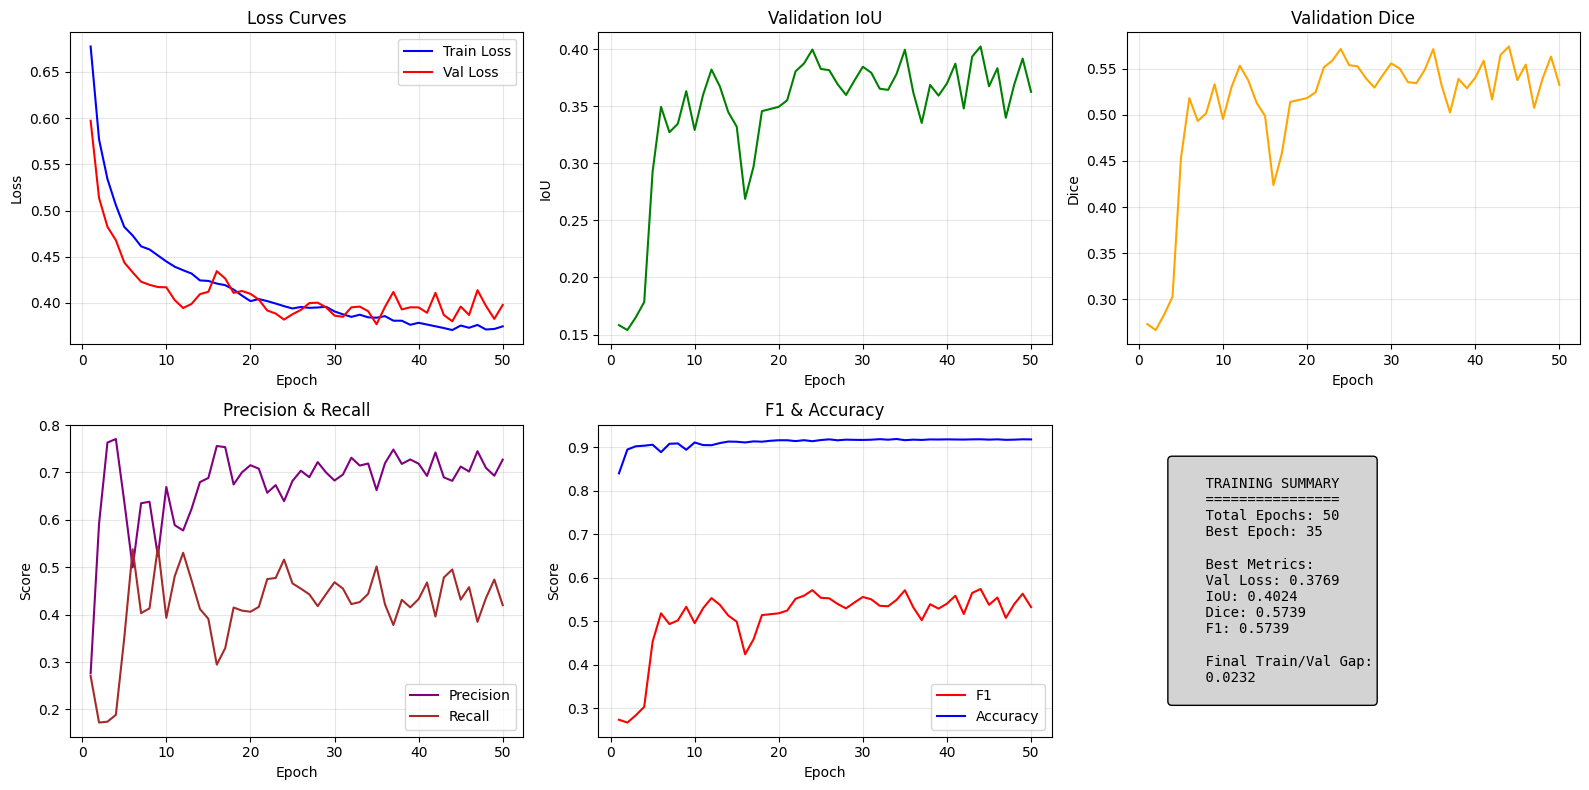


Test Metrics (With Dropout):
                      0
IoU        4.359292e-01
Dice       6.071737e-01
Precision  6.913170e-01
Recall     5.412908e-01
F1         6.071737e-01
Accuracy   9.257465e-01
TP         7.107900e+05
FP         3.173780e+05
FN         6.023490e+05
TN         1.075579e+07


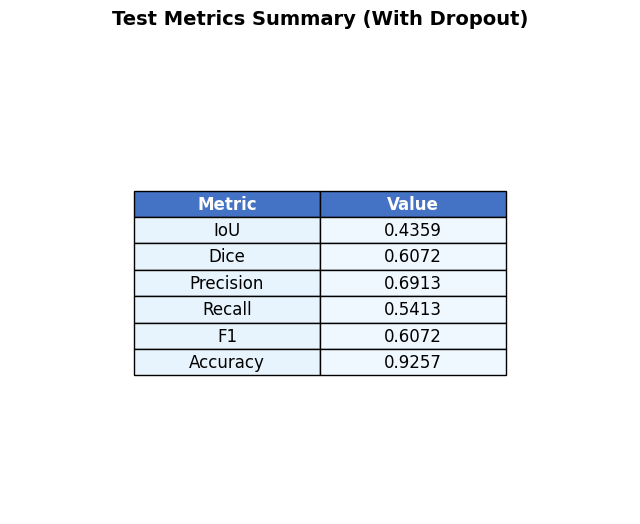

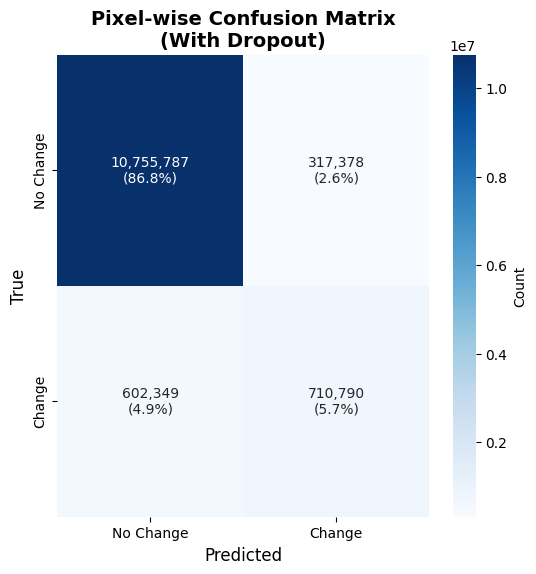


Confusion Matrix Breakdown:
True Negatives (No Change → No Change): 10,755,787
False Positives (No Change → Change): 317,378
False Negatives (Change → No Change): 602,349
True Positives (Change → Change): 710,790


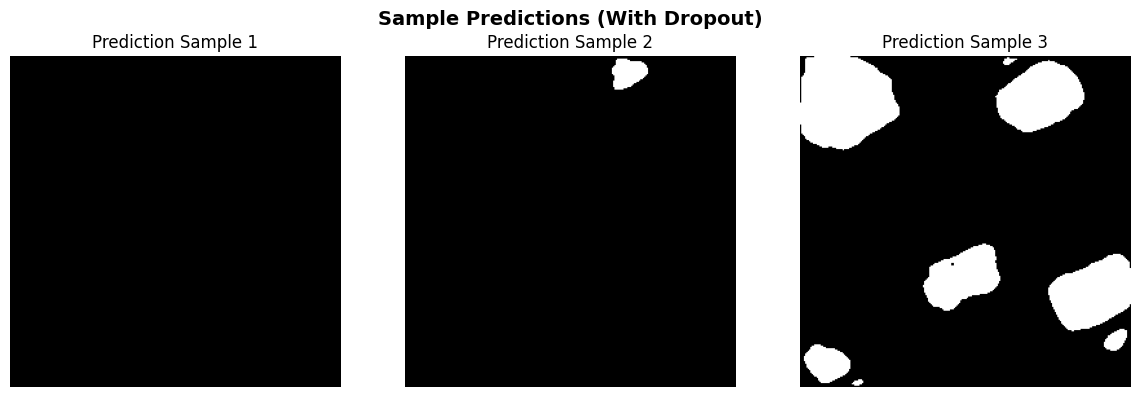


COMPARISON WITH ORIGINAL MODEL (if available)

Training Comparison (Final Epoch):
Metric          Original     With Dropout    Improvement 
------------------------------------------------------------
val_loss        0.4204       0.3978          -0.0226     
IoU             0.4106       0.3627          -0.0480     
Dice            0.5822       0.5323          -0.0499     
F1              0.5822       0.5323          -0.0499     

Test Metrics Comparison:
IoU             0.4523       0.4359          -0.0164     
Dice            0.6229       0.6072          -0.0157     
F1              0.6229       0.6072          -0.0157     
Precision       0.6055       0.6913          +0.0858     
Recall          0.6412       0.5413          -0.0999     

Visualization complete! All plots saved as PNG files.


In [17]:
# Visualization for custom U-Net++ results with dropout
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
import os

# Load training history (updated filename)
hist_df = pd.read_csv('training_history_unetpp_dropout.csv')
print('History head:')
print(hist_df.head())

# Create training plots
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(16,8))

# Plot 1: Loss curves
ax1.plot(hist_df['epoch'], hist_df['train_loss'], label='Train Loss', color='blue')
ax1.plot(hist_df['epoch'], hist_df['val_loss'], label='Val Loss', color='red')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: IoU
ax2.plot(hist_df['epoch'], hist_df['IoU'], label='IoU', color='green')
ax2.set_title('Validation IoU')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('IoU')
ax2.grid(True, alpha=0.3)

# Plot 3: Dice
ax3.plot(hist_df['epoch'], hist_df['Dice'], label='Dice', color='orange')
ax3.set_title('Validation Dice')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Dice')
ax3.grid(True, alpha=0.3)

# Plot 4: Precision & Recall
ax4.plot(hist_df['epoch'], hist_df['Precision'], label='Precision', color='purple')
ax4.plot(hist_df['epoch'], hist_df['Recall'], label='Recall', color='brown')
ax4.set_title('Precision & Recall')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Score')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: F1 & Accuracy
ax5.plot(hist_df['epoch'], hist_df['F1'], label='F1', color='red')
ax5.plot(hist_df['epoch'], hist_df['Accuracy'], label='Accuracy', color='blue')
ax5.set_title('F1 & Accuracy')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Score')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Summary statistics
ax6.axis('off')
if len(hist_df) > 0:
    best_epoch = hist_df.loc[hist_df['val_loss'].idxmin(), 'epoch']
    best_val_loss = hist_df['val_loss'].min()
    best_iou = hist_df['IoU'].max()
    best_dice = hist_df['Dice'].max()
    best_f1 = hist_df['F1'].max()
    
    summary_text = f"""
    TRAINING SUMMARY
    ================
    Total Epochs: {len(hist_df)}
    Best Epoch: {best_epoch}
    
    Best Metrics:
    Val Loss: {best_val_loss:.4f}
    IoU: {best_iou:.4f}
    Dice: {best_dice:.4f}
    F1: {best_f1:.4f}
    
    Final Train/Val Gap:
    {hist_df['val_loss'].iloc[-1] - hist_df['train_loss'].iloc[-1]:.4f}
    """
    ax6.text(0.1, 0.5, summary_text, fontsize=10, fontfamily='monospace',
             verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

plt.tight_layout()
plt.savefig('training_curves_dropout.png', dpi=150, bbox_inches='tight')
plt.show()

# Load and display test metrics (updated filename)
try:
    metrics_df = pd.read_csv('test_metrics_unetpp_dropout.csv')
    print('\nTest Metrics (With Dropout):')
    print(metrics_df.T)
    
    # Create a nice metrics table
    plt.figure(figsize=(8, 6))
    plt.axis('off')
    metrics_for_table = metrics_df[['IoU', 'Dice', 'Precision', 'Recall', 'F1', 'Accuracy']].iloc[0]
    
    table_data = []
    for metric, value in metrics_for_table.items():
        table_data.append([metric, f"{value:.4f}"])
    
    table = plt.table(cellText=table_data,
                     colLabels=['Metric', 'Value'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0.2, 0.3, 0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(table_data)):
        table[(i+1, 0)].set_facecolor('#E8F4FD')
        table[(i+1, 1)].set_facecolor('#F0F8FF')
    
    table[(0, 0)].set_facecolor('#4472C4')
    table[(0, 1)].set_facecolor('#4472C4')
    table[(0, 0)].set_text_props(weight='bold', color='white')
    table[(0, 1)].set_text_props(weight='bold', color='white')
    
    plt.title('Test Metrics Summary (With Dropout)', fontsize=14, fontweight='bold', pad=20)
    plt.savefig('test_metrics_table.png', dpi=150, bbox_inches='tight')
    plt.show()
    
except FileNotFoundError:
    print("Warning: test_metrics_unetpp_dropout.csv not found. Make sure you run the test evaluation first.")

# Confusion matrix heatmap (updated filename)
try:
    cm = np.loadtxt('confusion_matrix_unetpp_dropout.txt', dtype=int)
    plt.figure(figsize=(6,6))
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum() * 100
    
    # Create annotations with both counts and percentages
    annotations = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            count = cm[i,j]
            percent = cm_percent[i,j]
            row.append(f'{count:,}\n({percent:.1f}%)')
        annotations.append(row)
    
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', cbar_kws={'label': 'Count'})
    plt.title('Pixel-wise Confusion Matrix\n(With Dropout)', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    
    # Add labels
    plt.gca().set_xticklabels(['No Change', 'Change'])
    plt.gca().set_yticklabels(['No Change', 'Change'])
    
    plt.savefig('confusion_matrix_dropout.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print confusion matrix interpretation
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix Breakdown:")
    print(f"True Negatives (No Change → No Change): {tn:,}")
    print(f"False Positives (No Change → Change): {fp:,}")
    print(f"False Negatives (Change → No Change): {fn:,}")
    print(f"True Positives (Change → Change): {tp:,}")
    
except FileNotFoundError:
    print("Warning: confusion_matrix_unetpp_dropout.txt not found.")

# Show sample predictions (updated folder name)
pred_folder = 'test_predictions_unetpp_dropout'
if os.path.exists(pred_folder):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    for i in range(3):
        p_path = f'{pred_folder}/pred_{i}.png'
        if os.path.exists(p_path):
            img = Image.open(p_path)
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'Prediction Sample {i+1}', fontsize=12)
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f'Pred {i}\nNot Found', ha='center', va='center')
            axes[i].axis('off')
    
    plt.suptitle('Sample Predictions (With Dropout)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('sample_predictions_dropout.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f"Warning: Prediction folder '{pred_folder}' not found.")

# COMPARISON: Load original results if available
print("\n" + "="*60)
print("COMPARISON WITH ORIGINAL MODEL (if available)")
print("="*60)

try:
    # Try to load original results
    hist_orig = pd.read_csv('training_history_unetpp.csv')
    metrics_orig = pd.read_csv('test_metrics_unetpp.csv')
    
    # Compare final validation metrics
    final_dropout = hist_df.iloc[-1]
    final_orig = hist_orig.iloc[-1]
    
    print("\nTraining Comparison (Final Epoch):")
    print(f"{'Metric':<15} {'Original':<12} {'With Dropout':<15} {'Improvement':<12}")
    print("-" * 60)
    
    for metric in ['val_loss', 'IoU', 'Dice', 'F1']:
        orig_val = final_orig[metric]
        dropout_val = final_dropout[metric]
        
        if metric == 'val_loss':
            improvement = orig_val - dropout_val  # Lower is better for loss
            improvement_str = f"-{abs(improvement):.4f}" if improvement > 0 else f"+{abs(improvement):.4f}"
        else:
            improvement = dropout_val - orig_val  # Higher is better for metrics
            improvement_str = f"+{improvement:.4f}" if improvement > 0 else f"{improvement:.4f}"
        
        print(f"{metric:<15} {orig_val:<12.4f} {dropout_val:<15.4f} {improvement_str:<12}")
    
    # Test metrics comparison
    if 'test_metrics_unetpp_dropout.csv' in os.listdir('.'):
        print("\nTest Metrics Comparison:")
        test_orig = metrics_orig.iloc[0]
        test_dropout = metrics_df.iloc[0]
        
        for metric in ['IoU', 'Dice', 'F1', 'Precision', 'Recall']:
            orig_val = test_orig[metric]
            dropout_val = test_dropout[metric]
            improvement = dropout_val - orig_val
            improvement_str = f"+{improvement:.4f}" if improvement > 0 else f"{improvement:.4f}"
            print(f"{metric:<15} {orig_val:<12.4f} {dropout_val:<15.4f} {improvement_str:<12}")

except FileNotFoundError:
    print("Original model results not found. Skipping comparison.")

print("\nVisualization complete! All plots saved as PNG files.")